In [4]:
# import Liabrary

In [5]:
import random
import pandas as pd
import numpy as np
import os
import cv2
import gc

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torchvision.models as models
import torchvision.transforms.functional as F

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings(action='ignore') 
import torch, gc

from torch.optim  import lr_scheduler

from pycocotools.coco import COCO

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [11]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

In [34]:
h36m_cameras_extrinsic_params = {
    'S1': [
        {
            'orientation': [0.1407056450843811, -0.1500701755285263, -0.755240797996521, 0.6223280429840088],
            'translation': [1841.1070556640625, 4955.28466796875, 1563.4454345703125],
        },
        {
            'orientation': [0.6157187819480896, -0.764836311340332, -0.14833825826644897, 0.11794740706682205],
            'translation': [1761.278564453125, -5078.0068359375, 1606.2650146484375],
        },
        {
            'orientation': [0.14651472866535187, -0.14647851884365082, 0.7653023600578308, -0.6094175577163696],
            'translation': [-1846.7777099609375, 5215.04638671875, 1491.972412109375],
        },
        {
            'orientation': [0.5834008455276489, -0.7853162288665771, 0.14548823237419128, -0.14749594032764435],
            'translation': [-1794.7896728515625, -3722.698974609375, 1574.8927001953125],
        },
    ],
    'S2': [
        {},
        {},
        {},
        {},
    ],
    'S3': [
        {},
        {},
        {},
        {},
    ],
    'S4': [
        {},
        {},
        {},
        {},
    ],
    'S5': [
        {
            'orientation': [0.1467377245426178, -0.162370964884758, -0.7551892995834351, 0.6178938746452332],
            'translation': [2097.3916015625, 4880.94482421875, 1605.732421875],
        },
        {
            'orientation': [0.6159758567810059, -0.7626792192459106, -0.15728192031383514, 0.1189815029501915],
            'translation': [2031.7008056640625, -5167.93310546875, 1612.923095703125],
        },
        {
            'orientation': [0.14291371405124664, -0.12907841801643372, 0.7678384780883789, -0.6110143065452576],
            'translation': [-1620.5948486328125, 5171.65869140625, 1496.43701171875],
        },
        {
            'orientation': [0.5920479893684387, -0.7814217805862427, 0.1274748593568802, -0.15036417543888092],
            'translation': [-1637.1737060546875, -3867.3173828125, 1547.033203125],
        },
    ],
    'S6': [
        {
            'orientation': [0.1337897777557373, -0.15692396461963654, -0.7571090459823608, 0.6198879480361938],
            'translation': [1935.4517822265625, 4950.24560546875, 1618.0838623046875],
        },
        {
            'orientation': [0.6147197484970093, -0.7628812789916992, -0.16174767911434174, 0.11819244921207428],
            'translation': [1969.803955078125, -5128.73876953125, 1632.77880859375],
        },
        {
            'orientation': [0.1529948115348816, -0.13529130816459656, 0.7646096348762512, -0.6112781167030334],
            'translation': [-1769.596435546875, 5185.361328125, 1476.993408203125],
        },
        {
            'orientation': [0.5916101336479187, -0.7804774045944214, 0.12832270562648773, -0.1561593860387802],
            'translation': [-1721.668701171875, -3884.13134765625, 1540.4879150390625],
        },
    ],
    'S7': [
        {
            'orientation': [0.1435241848230362, -0.1631336808204651, -0.7548328638076782, 0.6188824772834778],
            'translation': [1974.512939453125, 4926.3544921875, 1597.8326416015625],
        },
        {
            'orientation': [0.6141672730445862, -0.7638262510299683, -0.1596645563840866, 0.1177929937839508],
            'translation': [1937.0584716796875, -5119.7900390625, 1631.5665283203125],
        },
        {
            'orientation': [0.14550060033798218, -0.12874816358089447, 0.7660516500473022, -0.6127139329910278],
            'translation': [-1741.8111572265625, 5208.24951171875, 1464.8245849609375],
        },
        {
            'orientation': [0.5912848114967346, -0.7821764349937439, 0.12445473670959473, -0.15196487307548523],
            'translation': [-1734.7105712890625, -3832.42138671875, 1548.5830078125],
        },
    ],
    'S8': [
        {
            'orientation': [0.14110587537288666, -0.15589867532253265, -0.7561917304992676, 0.619644045829773],
            'translation': [2150.65185546875, 4896.1611328125, 1611.9046630859375],
        },
        {
            'orientation': [0.6169601678848267, -0.7647668123245239, -0.14846350252628326, 0.11158157885074615],
            'translation': [2219.965576171875, -5148.453125, 1613.0440673828125],
        },
        {
            'orientation': [0.1471444070339203, -0.13377119600772858, 0.7670128345489502, -0.6100369691848755],
            'translation': [-1571.2215576171875, 5137.0185546875, 1498.1761474609375],
        },
        {
            'orientation': [0.5927824378013611, -0.7825870513916016, 0.12147816270589828, -0.14631995558738708],
            'translation': [-1476.913330078125, -3896.7412109375, 1547.97216796875],
        },
    ],
    'S9': [
        {
            'orientation': [0.15540587902069092, -0.15548215806484222, -0.7532095313072205, 0.6199594736099243],
            'translation': [2044.45849609375, 4935.1171875, 1481.2275390625],
        },
        {
            'orientation': [0.618784487247467, -0.7634735107421875, -0.14132238924503326, 0.11933968216180801],
            'translation': [1990.959716796875, -5123.810546875, 1568.8048095703125],
        },
        {
            'orientation': [0.13357827067375183, -0.1367100477218628, 0.7689454555511475, -0.6100738644599915],
            'translation': [-1670.9921875, 5211.98583984375, 1528.387939453125],
        },
        {
            'orientation': [0.5879399180412292, -0.7823407053947449, 0.1427614390850067, -0.14794869720935822],
            'translation': [-1696.04345703125, -3827.099853515625, 1591.4127197265625],
        },
    ],
    'S11': [
        {
            'orientation': [0.15232472121715546, -0.15442320704460144, -0.7547563314437866, 0.6191070079803467],
            'translation': [2098.440185546875, 4926.5546875, 1500.278564453125],
        },
        {
            'orientation': [0.6189449429512024, -0.7600917220115662, -0.15300633013248444, 0.1255258321762085],
            'translation': [2083.182373046875, -4912.1728515625, 1561.07861328125],
        },
        {
            'orientation': [0.14943228662014008, -0.15650227665901184, 0.7681233882904053, -0.6026304364204407],
            'translation': [-1609.8153076171875, 5177.3359375, 1537.896728515625],
        },
        {
            'orientation': [0.5894251465797424, -0.7818877100944519, 0.13991211354732513, -0.14715361595153809],
            'translation': [-1590.738037109375, -3854.1689453125, 1578.017578125],
        },
    ],
}

In [37]:
h36m_cameras_intrinsic_params = [{
        'id': '54138969',
        'center': [512.54150390625, 515.4514770507812],
        'focal_length': [1145.0494384765625, 1143.7811279296875],
        'radial_distortion': [-0.20709891617298126, 0.24777518212795258, -0.0030751503072679043],
        'tangential_distortion': [-0.0009756988729350269, -0.00142447161488235],
        'res_w': 1000,
        'res_h': 1002,
        'azimuth': 70}, # Only used for visualization
    {
        'id': '55011271',
        'center': [508.8486328125, 508.0649108886719],
        'focal_length': [1149.6756591796875, 1147.5916748046875],
        'radial_distortion': [-0.1942136287689209, 0.2404085397720337, 0.006819975562393665],
        'tangential_distortion': [-0.0016190266469493508, -0.0027408944442868233],
        'res_w': 1000,
        'res_h': 1000,
        'azimuth': -70, # Only used for visualization
    },
    {
        'id': '58860488',
        'center': [519.8158569335938, 501.40264892578125],
        'focal_length': [1149.1407470703125, 1148.7989501953125],
        'radial_distortion': [-0.2083381861448288, 0.25548800826072693, -0.0024604974314570427],
        'tangential_distortion': [0.0014843869721516967, -0.0007599993259645998],
        'res_w': 1000,
        'res_h': 1000,
        'azimuth': 110, # Only used for visualization
    },
    {
        'id': '60457274',
        'center': [514.9682006835938, 501.88201904296875],
        'focal_length': [1145.5113525390625, 1144.77392578125],
        'radial_distortion': [-0.198384091258049, 0.21832367777824402, -0.008947807364165783],
        'tangential_distortion': [-0.0005872055771760643, -0.0018133620033040643],
        'res_w': 1000,
        'res_h': 1002,
        'azimuth': -110, # Only used for visualization
    }]

In [35]:
import copy

x is : [[-0.1413  0.0691  0.9339]
 [-0.2737  0.0585  0.9398]
 [-0.2422  0.1223  0.5027]
 [-0.218   0.2017  0.0561]
 [-0.0089  0.0798  0.928 ]
 [-0.0218  0.1186  0.487 ]
 [-0.0182  0.196   0.0395]
 [-0.1586  0.1028  1.1643]
 [-0.1667  0.1129  1.4211]
 [-0.1802  0.0541  1.5261]
 [-0.1777  0.1515  1.5873]
 [-0.0347  0.1134  1.3476]
 [ 0.0562  0.0962  1.0845]
 [ 0.1222  0.0305  0.8507]
 [-0.2925  0.1153  1.3376]
 [-0.3588  0.1196  1.0667]
 [-0.4005  0.0589  0.826 ]]


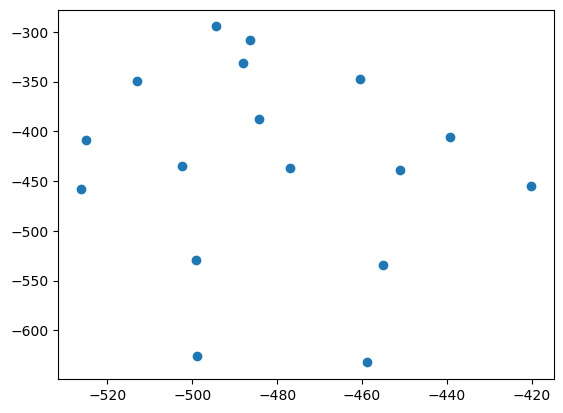

In [95]:
# make dataset test
_cameras_ex = copy.deepcopy(h36m_cameras_extrinsic_params)
_cameras_in = copy.deepcopy(h36m_cameras_intrinsic_params)
data_3d = np.load('data_3d_h36m.npz',allow_pickle=True)
data_2d_gt = np.load('data_2d_h36m_gt.npz',allow_pickle=True)
data_2d_cpn = np.load('data_2d_h36m_cpn_ft_h36m_dbb.npz',allow_pickle=True)

data2 = data_2d_gt['positions_2d'].item()
data3 = data_3d['positions_3d'].item()

_data2 = {}
for subject, actions in data2.items():
    #print(subject)
    _data2[subject] = {}
    #print(actions.items())
    for action_name, positions in actions.items():
        _data2[subject][action_name] = {
                    'positions': positions,
                    'cameras_in': _cameras_in,
                    'cameras_ex': _cameras_ex[subject],}
_data3 = {}
for subject, actions in data3.items():
    #print(subject)
    _data3[subject] = {}
    #print(actions.items())
    for action_name, positions in actions.items():
         _data3[subject][action_name] = {
                    'positions': positions,
                    'cameras_in': _cameras_in,
                    'cameras_ex': _cameras_ex[subject],}

data2d_test = np.array(_data2['S1']['Walking']['positions'])[0][0]
data3d_test = np.array(_data3['S1']['Walking']['positions'])[0]


data3d_test = np.delete(data3d_test, [4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31], 0)

print(f'x is : {data3d_test}')

data_2d_x = data2d_test[:,0]
data_2d_y = data2d_test[:,1]

import matplotlib.pyplot as plt
plt.scatter(-data_2d_x,-data_2d_y)

In [96]:
import numpy as np
 
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [168]:
n = 3
#make intrinsic matrix
data2d_intrinsic = np.array(_data2['S1']['Walking']['cameras_in'][n]).item()
#make extrinsic matrix
data3d_extrinsic = np.array(_data3['S1']['Walking']['cameras_ex'][n]).item()

print(data2d_intrinsic)
print(data3d_extrinsic)



{'id': '60457274', 'center': [514.9682006835938, 501.88201904296875], 'focal_length': [1145.5113525390625, 1144.77392578125], 'radial_distortion': [-0.198384091258049, 0.21832367777824402, -0.008947807364165783], 'tangential_distortion': [-0.0005872055771760643, -0.0018133620033040643], 'res_w': 1000, 'res_h': 1002, 'azimuth': -110}
{'orientation': [0.5834008455276489, -0.7853162288665771, 0.14548823237419128, -0.14749594032764435], 'translation': [-1794.7896728515625, -3722.698974609375, 1574.8927001953125]}


In [176]:
# R
np.set_printoptions(precision=4, suppress=True)
R = quaternion_rotation_matrix(data3d_extrinsic['orientation']).T
print(f'R is :{R}')

R is :[[ 0.9142 -0.4006  0.0619]
 [-0.0564 -0.277  -0.9592]
 [ 0.4014  0.8734 -0.2758]]


In [177]:
t = [
          [[-346.05078140028075],[546.9807793144001],[5474.481087434061]],
          [[251.42516271750836],[420.9422103702068],[5588.195881837821]],
          [[480.482559565337],[253.83237471361554],[5704.2076793704555]],
          [[51.88347637559197],[378.4208425426766],[4406.149140878431]]]
t[n]

t = np.array([data3d_extrinsic['translation']]).T
t

array([[-1794.7897],
       [-3722.699 ],
       [ 1574.8927]])

In [178]:
Rt = np.hstack([R,t])
print(Rt)

[[    0.9142    -0.4006     0.0619 -1794.7897]
 [   -0.0564    -0.277     -0.9592 -3722.699 ]
 [    0.4014     0.8734    -0.2758  1574.8927]]


In [179]:
intrinsicp = np.array([[data2d_intrinsic['focal_length'][0],0,data2d_intrinsic['center'][0]],
            [0,data2d_intrinsic['focal_length'][1],data2d_intrinsic['center'][1]],
            [0,0,1]])
print(instrinsicp)

[[1145.0494    0.      512.5415]
 [   0.     1143.7811  515.4515]
 [   0.        0.        1.    ]]


In [180]:
keypoint = np.hstack([data3d_test,np.full((17,1),1)])
keypoint = keypoint.T

In [181]:
keypoint

array([[-0.1413, -0.2737, -0.2422, -0.218 , -0.0089, -0.0218, -0.0182,
        -0.1586, -0.1667, -0.1802, -0.1777, -0.0347,  0.0562,  0.1222,
        -0.2925, -0.3588, -0.4005],
       [ 0.0691,  0.0585,  0.1223,  0.2017,  0.0798,  0.1186,  0.196 ,
         0.1028,  0.1129,  0.0541,  0.1515,  0.1134,  0.0962,  0.0305,
         0.1153,  0.1196,  0.0589],
       [ 0.9339,  0.9398,  0.5027,  0.0561,  0.928 ,  0.487 ,  0.0395,
         1.1643,  1.4211,  1.5261,  1.5873,  1.3476,  1.0845,  0.8507,
         1.3376,  1.0667,  0.826 ],
       [ 1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,
         1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,  1.    ,
         1.    ,  1.    ,  1.    ]])

In [192]:
# test = np.matmul(Rt,keypoint).T
# print(test)
# test[:,1:] -= test[:,:1]

# print(test)

[[-1794.8888 -3723.606   1574.6388]
 [-1795.0052 -3723.6012  1574.5747]
 [-1795.0289 -3723.2013  1574.7636]
 [-1795.0662 -3722.7964  1574.9659]
 [-1794.7724 -3723.6108  1574.7029]
 [-1794.827  -3723.1978  1574.8532]
 [-1794.8824 -3722.7901  1575.0457]
 [-1794.9037 -3723.8353  1574.5978]
 [-1794.8993 -3724.0839  1574.5325]
 [-1794.8816 -3724.1677  1574.4468]
 [-1794.9146 -3724.2535  1574.5159]
 [-1794.7834 -3724.0211  1574.6062]
 [-1794.7097 -3723.7691  1574.7002]
 [-1794.6375 -3723.5303  1574.7338]
 [-1795.0205 -3723.9975  1574.5072]
 [-1795.0996 -3723.7351  1574.5589]
 [-1795.1283 -3723.485   1574.5556]]
[[-1794.8888 -1928.7172  3369.5275]
 [-1795.0052 -1928.5961  3369.5799]
 [-1795.0289 -1928.1724  3369.7925]
 [-1795.0662 -1927.7301  3370.0321]
 [-1794.7724 -1928.8384  3369.4752]
 [-1794.827  -1928.3708  3369.6802]
 [-1794.8824 -1927.9077  3369.9281]
 [-1794.9037 -1928.9316  3369.5015]
 [-1794.8993 -1929.1847  3369.4317]
 [-1794.8816 -1929.2861  3369.3284]
 [-1794.9146 -1929.3389  33

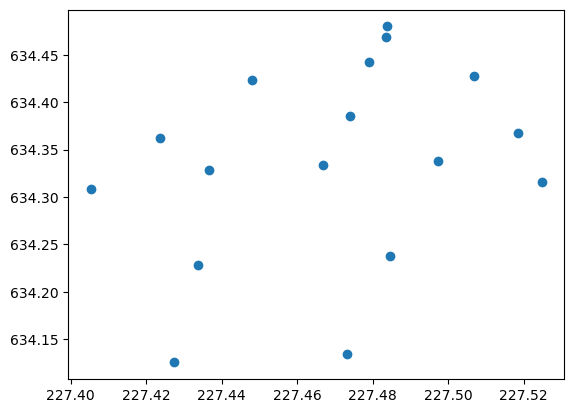

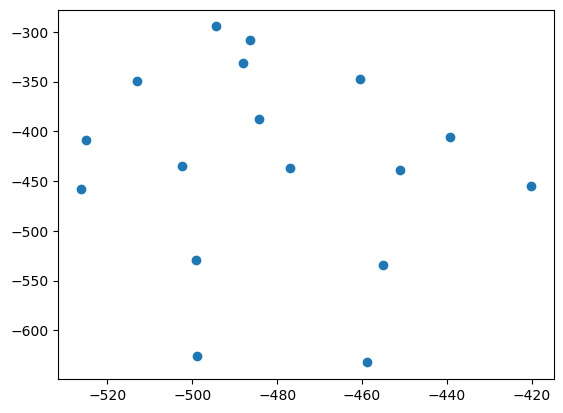

In [182]:
result = np.matmul(intrinsicp,Rt)
result = np.matmul(result,keypoint)
final = result.T/5474.1

x = final[:,0]
y = final[:,1]

plt.scatter(-x,-y)
plt.show()
plt.scatter(-data_2d_x,-data_2d_y)
plt.show()

In [188]:
def wrap(func, *args, unsqueeze=False):
    """
    Wrap a torch function so it can be called with NumPy arrays.
    Input and return types are seamlessly converted.
    """
    
    # Convert input types where applicable
    args = list(args)
    for i, arg in enumerate(args):
        if type(arg) == np.ndarray:
            args[i] = torch.from_numpy(arg)
            if unsqueeze:
                args[i] = args[i].unsqueeze(0)
        
    result = func(*args)
    
    # Convert output types where applicable
    if isinstance(result, tuple):
        result = list(result)
        for i, res in enumerate(result):
            if type(res) == torch.Tensor:
                if unsqueeze:
                    res = res.squeeze(0)
                result[i] = res.numpy()
        return tuple(result)
    elif type(result) == torch.Tensor:
        if unsqueeze:
            result = result.squeeze(0)
        return result.numpy()
    else:
        return result
def qrot(q, v):
    """
    Rotate vector(s) v about the rotation described by quaternion(s) q.
    Expects a tensor of shape (*, 4) for q and a tensor of shape (*, 3) for v,
    where * denotes any number of dimensions.
    Returns a tensor of shape (*, 3).
    """
    assert q.shape[-1] == 4
    assert v.shape[-1] == 3
    assert q.shape[:-1] == v.shape[:-1]

    qvec = q[..., 1:]
    uv = torch.cross(qvec, v, dim=len(q.shape)-1)
    uuv = torch.cross(qvec, uv, dim=len(q.shape)-1)
    return (v + 2 * (q[..., :1] * uv + uuv))
    
    
def qinverse(q, inplace=False):
    # We assume the quaternion to be normalized
    if inplace:
        q[..., 1:] *= -1
        return q
    else:
        w = q[..., :1]
        xyz = q[..., 1:]
        return torch.cat((w, -xyz), dim=len(q.shape)-1)
    
def world_to_camera(X, R, t):
    Rt = wrap(qinverse, R) # Invert rotation
    return wrap(qrot, np.tile(Rt, (*X.shape[:-1], 1)), X - t) # Rotate and translate

print(data3d_test)
print(data3d_extrinsic['orientation'])
print(data3d_extrinsic['translation'])

pose_3d = world_to_camera(data3d_test,data3d_extrinsic['orientation'],data3d_extrinsic['translation'])

[[-0.1413  0.0691  0.9339]
 [-0.2737  0.0585  0.9398]
 [-0.2422  0.1223  0.5027]
 [-0.218   0.2017  0.0561]
 [-0.0089  0.0798  0.928 ]
 [-0.0218  0.1186  0.487 ]
 [-0.0182  0.196   0.0395]
 [-0.1586  0.1028  1.1643]
 [-0.1667  0.1129  1.4211]
 [-0.1802  0.0541  1.5261]
 [-0.1777  0.1515  1.5873]
 [-0.0347  0.1134  1.3476]
 [ 0.0562  0.0962  1.0845]
 [ 0.1222  0.0305  0.8507]
 [-0.2925  0.1153  1.3376]
 [-0.3588  0.1196  1.0667]
 [-0.4005  0.0589  0.826 ]]
[0.5834008455276489, -0.7853162288665771, 0.14548823237419128, -0.14749594032764435]
[-1794.7896728515625, -3722.698974609375, 1574.8927001953125]


TypeError: list indices must be integers or slices, not tuple

In [182]:
dictionary = [{
        'id': '54138969',
        'center': [512.54150390625, 515.4514770507812],
        'focal_length': [1145.0494384765625, 1143.7811279296875],
        'radial_distortion': [-0.20709891617298126, 0.24777518212795258, -0.0030751503072679043],
        'tangential_distortion': [-0.0009756988729350269, -0.00142447161488235],
        'res_w': 1000,
        'res_h': 1002,
        'azimuth': 70}, # Only used for visualization
    {
        'id': '55011271',
        'center': [508.8486328125, 508.0649108886719],
        'focal_length': [1149.6756591796875, 1147.5916748046875],
        'radial_distortion': [-0.1942136287689209, 0.2404085397720337, 0.006819975562393665],
        'tangential_distortion': [-0.0016190266469493508, -0.0027408944442868233],
        'res_w': 1000,
        'res_h': 1000,
        'azimuth': -70, # Only used for visualization
    },
    {
        'id': '58860488',
        'center': [519.8158569335938, 501.40264892578125],
        'focal_length': [1149.1407470703125, 1148.7989501953125],
        'radial_distortion': [-0.2083381861448288, 0.25548800826072693, -0.0024604974314570427],
        'tangential_distortion': [0.0014843869721516967, -0.0007599993259645998],
        'res_w': 1000,
        'res_h': 1000,
        'azimuth': 110, # Only used for visualization
    },
    {
        'id': '60457274',
        'center': [514.9682006835938, 501.88201904296875],
        'focal_length': [1145.5113525390625, 1144.77392578125],
        'radial_distortion': [-0.198384091258049, 0.21832367777824402, -0.008947807364165783],
        'tangential_distortion': [-0.0005872055771760643, -0.0018133620033040643],
        'res_w': 1000,
        'res_h': 1002,
        'azimuth': -110, # Only used for visualization
    }]
    

orientation = [0.1407056450843811, -0.1500701755285263, -0.755240797996521, 0.6223280429840088]
translation = [1841.1070556640625, 4955.28466796875, 1563.4454345703125]

#cx,cy :영상 중심 좌표 w/2,h/2
#p'' x = fx*x/z+cx, y = fy*y/z+cy

In [184]:
import numpy as np
 
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[0]
    q1 = Q[1]
    q2 = Q[2]
    q3 = Q[3]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [312]:
data_2d_test = _data['S1']['Directions 1']['positions'][0][100][0]
data_3d_test = _data2['S1']['Directions 1']['positions'][100][0]

print(data_2d_test)
print(data_3d_test)

[488.813  436.5566]
[-0.1773  0.1258  0.9402]


In [352]:
n =0
h36m_cameras_extrinsic_params = {
    'S1': [
        {
            'orientation': [0.1407056450843811, -0.1500701755285263, -0.755240797996521, 0.6223280429840088],
            'translation': [1841.1070556640625, 4955.28466796875, 1563.4454345703125],
        },
        {
            'orientation': [0.6157187819480896, -0.764836311340332, -0.14833825826644897, 0.11794740706682205],
            'translation': [1761.278564453125, -5078.0068359375, 1606.2650146484375],
        },
        {
            'orientation': [0.14651472866535187, -0.14647851884365082, 0.7653023600578308, -0.6094175577163696],
            'translation': [-1846.7777099609375, 5215.04638671875, 1491.972412109375],
        },
        {
            'orientation': [0.5834008455276489, -0.7853162288665771, 0.14548823237419128, -0.14749594032764435],
            'translation': [-1794.7896728515625, -3722.698974609375, 1574.8927001953125],
        },
    ]}

np.set_printoptions(precision=4, suppress=True)
R = quaternion_rotation_matrix(h36m_cameras_extrinsic_params['S1'][n]['orientation']).T
print(f'R is :{R}')
t = [
          [[-346.05078140028075],[546.9807793144001],[5474.481087434061]],
          [[251.42516271750836],[420.9422103702068],[5588.195881837821]],
          [[480.482559565337],[253.83237471361554],[5704.2076793704555]],
          [[51.88347637559197],[378.4208425426766],[4406.149140878431]]
t = np.array([h36m_cameras_extrinsic_params['S1'][n]['translation']]).T
print(f't is {t}')
Rt = np.hstack([R,t0])

data_x = data_3d_test[0]
data_y = data_3d_test[1]
data_z = data_3d_test[2]

point_3d = np.hstack([[[data_x,data_y,data_z,1]]]).T

instrinsic = [{
        'id': '54138969',
        'center': [512.54150390625, 515.4514770507812],
        'focal_length': [1145.0494384765625, 1143.7811279296875],
        'radial_distortion': [-0.20709891617298126, 0.24777518212795258, -0.0030751503072679043],
        'tangential_distortion': [-0.0009756988729350269, -0.00142447161488235],
        'res_w': 1000,
        'res_h': 1002,
        'azimuth': 70}, # Only used for visualization
    {
        'id': '55011271',
        'center': [508.8486328125, 508.0649108886719],
        'focal_length': [1149.6756591796875, 1147.5916748046875],
        'radial_distortion': [-0.1942136287689209, 0.2404085397720337, 0.006819975562393665],
        'tangential_distortion': [-0.0016190266469493508, -0.0027408944442868233],
        'res_w': 1000,
        'res_h': 1000,
        'azimuth': -70, # Only used for visualization
    },
    {
        'id': '58860488',
        'center': [519.8158569335938, 501.40264892578125],
        'focal_length': [1149.1407470703125, 1148.7989501953125],
        'radial_distortion': [-0.2083381861448288, 0.25548800826072693, -0.0024604974314570427],
        'tangential_distortion': [0.0014843869721516967, -0.0007599993259645998],
        'res_w': 1000,
        'res_h': 1000,
        'azimuth': 110, # Only used for visualization
    },
    {
        'id': '60457274',
        'center': [514.9682006835938, 501.88201904296875],
        'focal_length': [1145.5113525390625, 1144.77392578125],
        'radial_distortion': [-0.198384091258049, 0.21832367777824402, -0.008947807364165783],
        'tangential_distortion': [-0.0005872055771760643, -0.0018133620033040643],
        'res_w': 1000,
        'res_h': 1002,
        'azimuth': -110, # Only used for visualization
    }] # Only used for visualization

instrinsicp = np.array([[instrinsic[n]['focal_length'][0],0,instrinsic[n]['center'][0]],
            [0,instrinsic[n]['focal_length'][1],instrinsic[n]['center'][1]],
            [0,0,1]])

print(f'instrinsic parameter is : {instrinsicp}')
#result = np.matmul(instrinsicp.T,Rt)
#result = np.matmul(result,point_3d)
print(f'point_3d is : {point_3d.T}')
result1 = np.matmul(Rt,point_3d) #x,y,z
#print(result1)

result2 = np.matmul(instrinsicp,result1)
print(f'result is : {(result2/result2[2]).T}')

#print(result)
print(f'answer is :{data_2d_test}')
#result3 = np.matmul(instrinsicp,point_3d[:3])
#print(result3)

R is :[[-0.9154  0.4018  0.0257]
 [ 0.0515  0.1804 -0.9822]
 [-0.3993 -0.8978 -0.1858]]
t is [[1841.1071]
 [4955.2847]
 [1563.4454]]
instrinsic parameter is : [[1145.0494    0.      512.5415]
 [   0.     1143.7811  515.4515]
 [   0.        0.        1.    ]]
point_3d is : [[-0.1773  0.1258  0.9402  1.    ]]
result is : [[440.2078 629.5464   1.    ]]
answer is :[488.813  436.5566]
[[278.9183]
 [628.5454]
 [  0.9402]]


In [227]:
# test_x = focal_length_x * 3d_x / 3d_z +w/2
# 473.68362, 444.9426
#data_x = -0.091679
#data_y = 0.15440401
#data_z = 0.907261
#data_x = result[0]
#data_y = result[1]
#data_z = result[2]
test_x = 1145.0494384765625 *data_x / data_z + 512.54150390625
print(test_x)

test_y = -1143.7811279296875 *data_y / data_z + 515.4514770507812
print(test_y)

[2131480.83816515]
[-4735619.89132116]


In [179]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
    #remove_joints([4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31])
keypoint = _data2['S1']['Directions 1']['positions'][0]
print(keypoint)
'''
keypoint = _data2['S1']['Direction 1']['positions'][0]
x = keypoint[:,0]
y = keypoint[:,1]
z = keypoint[:,2]
print(x)
x = np.delete(x, [4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31], 0)
print(f'x is : {x}')
y = np.delete(y, [4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31], 0)
print(f'y is : {y}')
z = np.delete(z, [4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31], 0)
print(f'z is : {z}')
print(x.shape)

fig = plt.figure(figsize = (5,5))
ax = fig.gca(projection='3d')
ax.view_init(10,0)

ax.scatter(x,y,z,marker = 'o', s=15, c='darkgreen')
'''

[[-0.091679    0.15440401  0.907261  ]
 [-0.22323565  0.16380551  0.89053416]
 [-0.18847029  0.01407711  0.4751688 ]
 [-0.26184055  0.18655287  0.0614389 ]
 [-0.26462787  0.02895642  0.02083458]
 [-0.26693124 -0.04576369  0.02687732]
 [ 0.03987789  0.14500248  0.9239878 ]
 [-0.01167599  0.1608992   0.48439148]
 [-0.05155029  0.22014625  0.03583438]
 [-0.04052278  0.05826785  0.02291116]
 [-0.03355924 -0.01602683  0.03044794]
 [-0.09169202  0.15439798  0.9073599 ]
 [-0.1323478   0.21573019  1.1288396 ]
 [-0.0971674   0.20234434  1.3831466 ]
 [-0.11297075  0.12796944  1.4774457 ]
 [-0.12003291  0.19096476  1.5733999 ]
 [-0.0971674   0.20234434  1.3831466 ]
 [ 0.02589545  0.19235948  1.2961571 ]
 [ 0.10710583  0.1160503   1.0405062 ]
 [ 0.12983815 -0.0480249   0.85094804]
 [ 0.12983815 -0.0480249   0.85094804]
 [ 0.0564649  -0.1125178   0.87232465]
 [ 0.16202076 -0.10872367  0.7782846 ]
 [ 0.16202076 -0.10872367  0.7782846 ]
 [-0.0971674   0.20234434  1.3831466 ]
 [-0.23036957  0.20317921

"\nkeypoint = _data2['S1']['Direction 1']['positions'][0]\nx = keypoint[:,0]\ny = keypoint[:,1]\nz = keypoint[:,2]\nprint(x)\nx = np.delete(x, [4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31], 0)\nprint(f'x is : {x}')\ny = np.delete(y, [4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31], 0)\nprint(f'y is : {y}')\nz = np.delete(z, [4, 5, 9, 10, 11, 16, 20, 21, 22, 23, 24, 28, 29, 30, 31], 0)\nprint(f'z is : {z}')\nprint(x.shape)\n\nfig = plt.figure(figsize = (5,5))\nax = fig.gca(projection='3d')\nax.view_init(10,0)\n\nax.scatter(x,y,z,marker = 'o', s=15, c='darkgreen')\n"

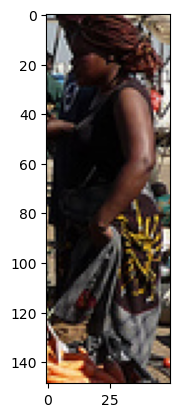

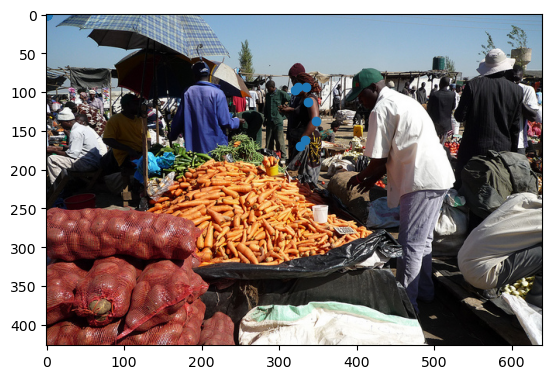

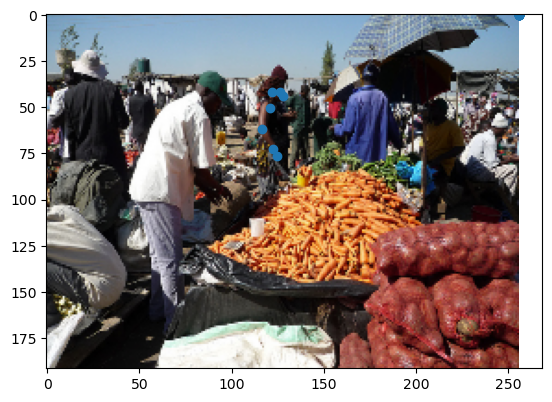

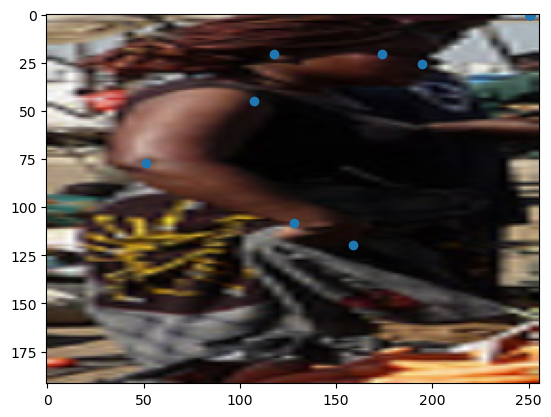

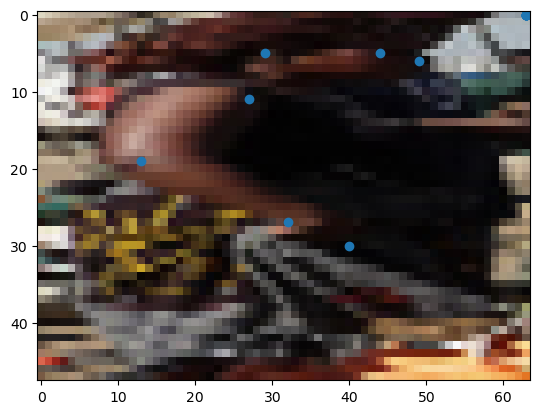

In [172]:
#for test dataset, dataloader
import matplotlib.pyplot as plt
index = 4
img_id = valid_anns_test[index]['image_id']
img_path = f'{train_image_folder}/{str(img_id).zfill(12)}.jpg'

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_height = image.shape[0]
image_width = image.shape[1]
#print(image_height)
#print(image_width)

x,y,w,h = valid_anns_test[index]['bbox']
x = int(x+0.5); y = int(y+0.5); w = int(w+0.5); h = int(h+0.5);

cropped_img = image[y:y+h,x:x+w]
plt.imshow(cropped_img)
plt.show()

label = valid_anns_test[index]['keypoints']
label = np.array(label).reshape(-1,3)
keypoints = label[:,:2]
plt.scatter(keypoints[:,0],keypoints[:,1])
plt.imshow(image)
plt.show()
#print(keypoints)

cropped_label = keypoints.copy()
cropped_label[:,0] = cropped_label[:,0]-x
cropped_label[:,1] = cropped_label[:,1]-y
cropped_label[cropped_label<0] = 0 

#print(cropped_label)
class_labels = [
        "nose",
        "left_eye",
        "right_eye",
        "left_ear",
        "right_ear",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle"
        ]
transform = A.Compose([
                        #A.HorizontalFlip(p=1),
                        HorizontalFlipEx(p=1),
                        #A.VerticalFlip(p=1),
                        #VerticalFlipEx(p=1),
                        #A.Rotate(border_mode=cv2.BORDER_REPLICATE,p=1,crop_border=False),
                        #A.Rotate(p=1),
                        #A.RandomRotate90(p=1),
                        #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),
                        #A.Crop(x_min = x1, y_min = y1, x_max = x2, y_max = y2, always_apply=True, p=1.0)
                        A.Resize(192,256),
                        #A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                        #ToTensorV2(),
                        ], keypoint_params=A.KeypointParams(format='xy', label_fields=['class_labels']))
# transform
transformed = transform(image=image, keypoints=keypoints, class_labels = class_labels)
cropped_transformed = transform(image=cropped_img, keypoints=cropped_label, class_labels = class_labels)
transformed_image = transformed['image']
plt.imshow(transformed_image)

transformed_keypoints = np.array(transformed['keypoints'])
#print(np.array(transformed_keypoints))
plt.scatter(np.array(transformed_keypoints)[:,0],np.array(transformed_keypoints)[:,1])
plt.show()
transformed_class_labels = transformed['class_labels']
##############################################################################
# reszie 64x48
transformed_keypoints[:,0] = (transformed_keypoints[:,0]*(64/image_width)+0.5).astype(int)
transformed_keypoints[:,1] = (transformed_keypoints[:,1]*(48/image_height)+0.5).astype(int)
transformed_image = np.resize(transformed_image,(48,64))
#print(transformed_image.shape)
#plt.imshow(transformed_image)
#plt.scatter(np.array(transformed_keypoints)[:,0],np.array(transformed_keypoints)[:,1])
#plt.show()
##############################################################################
#crop
cropped_transformed_image = cropped_transformed['image']
cropped_transformed_keypoints = np.array(cropped_transformed['keypoints'])
cropped_transformed_class_labels = cropped_transformed['class_labels']
plt.imshow(cropped_transformed_image)
plt.scatter(np.array(cropped_transformed_keypoints)[:,0],np.array(cropped_transformed_keypoints)[:,1])
plt.show()
##############################################################################
cropped_image_height = cropped_img.shape[0]
cropped_image_width = cropped_img.shape[1]

#print(cropped_image_height)
#print(cropped_image_width)
cropped_resized_transformed_image = cv2.resize(cropped_transformed_image,(64,48))
#plt.imshow(cropped_resized_transformed_image)
#plt.show()
###############################################################################
#print(cropped_transformed_keypoints)
cropped_resized_transformed_keypoints = cropped_transformed_keypoints.copy()
#cropped_resized_transformed_keypoints[:,0] = (cropped_transformed_keypoints[:,0]*(64/cropped_image_width)+0.5).astype(int)
#cropped_resized_transformed_keypoints[:,1] = (cropped_transformed_keypoints[:,1]*(48/cropped_image_height)+0.5).astype(int)
a = dict(zip(cropped_transformed_class_labels, cropped_resized_transformed_keypoints))


cropped_resized_transformed_keypoints[:,0] = (cropped_transformed_keypoints[:,0]*(64/256)+0.5).astype(int)
cropped_resized_transformed_keypoints[:,1] = (cropped_transformed_keypoints[:,1]*(48/192)+0.5).astype(int)

#print(cropped_resized_transformed_keypoints)
plt.imshow(cropped_resized_transformed_image)
plt.scatter(np.array(cropped_resized_transformed_keypoints)[:,0],np.array(cropped_resized_transformed_keypoints)[:,1])
plt.show()
#print(cropped_transformed_class_labels)
#print(a)

In [81]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, label_path, transforms=None):
        self.class_labels = [
        "nose",
        "left_eye",
        "right_eye",
        "left_ear",
        "right_ear",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle"
        ]
            
        self.transforms = transforms
        
        self.image_folder = image_folder
        self.label_paths = label_path
        self.coco = COCO(label_path)
        personIds = self.coco.getCatIds(catNms=['person'])
        self.imgIds = self.coco.getImgIds(catIds=personIds)
        self.annIds = self.coco.getAnnIds(catIds=personIds,imgIds = self.imgIds)
        
        self.anns = self.coco.loadAnns(self.annIds)
        self.valid_anns = []
        for ann in self.anns:
            if max(ann['keypoints']) == 0:
                continue
            else:
                self.valid_anns.append(ann)
        
    #ann의 길이를 줄이고 시작하기
    def __getitem__(self, index):
        
        # image 불러오기
        img_id = self.valid_anns[index]['image_id']
        img_path = f'{self.image_folder}/{str(img_id).zfill(12)}.jpg'
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # label 불러오기
        label = self.valid_anns[index]['keypoints']
        label = np.array(label).reshape(-1,3)
        keypoints = label[:,:2]
        
        # label의 쓰레기값 찾기
        garbage = np.where(keypoints==0)
        garbage = list(zip(garbage[0],garbage[1]))
        
        # bbox 불러와서 image crop
        x,y,w,h = self.valid_anns[index]['bbox']
        x = int(x+0.5); y = int(y+0.5); w = int(w+0.5); h = int(h+0.5);
        cropped_image = image[y:y+h,x:x+w]
        
        # crop한거 만큼 value 수정
        cropped_keypoints = keypoints.copy()
        cropped_keypoints[:,0] = cropped_keypoints[:,0]-x
        cropped_keypoints[:,1] = cropped_keypoints[:,1]-y
        cropped_keypoints[cropped_keypoints<0] = 0 
        
        # augmentation
        if self.transforms is not None:
            transformed = self.transforms(image=cropped_image, keypoints=cropped_keypoints, class_labels = self.class_labels)
            transformed_image = transformed['image']
            transformed_keypoints = np.array(transformed['keypoints'])
            
        
        # heatmap을 위한 keypoint 수정 (64x48)
        transformed_keypoints[:,0] = (transformed_keypoints[:,0]*(64/256)+0.5).astype(int)
        transformed_keypoints[:,1] = (transformed_keypoints[:,1]*(48/192)+0.5).astype(int)    
        for i in garbage:
            transformed_keypoints[i[0],i[1]] = -10000
        #print(dict(zip(transformed_class_labels ,transformed_keypoints)))        
        return transformed_image, transformed_keypoints
    
    def __len__(self):
        return len(self.valid_anns)


In [82]:
#Augmentation

In [83]:
class HorizontalFlipEx(A.HorizontalFlip):
    swap_columns = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]

    def apply_to_keypoints(self, keypoints, **params):
        keypoints = super().apply_to_keypoints(keypoints, **params)

        # left/right 키포인트들은 서로 swap해주기
        for a, b in self.swap_columns:
            temp1 = deepcopy(keypoints[a])
            temp2 = deepcopy(keypoints[b])
            keypoints[a] = temp2
            keypoints[b] = temp1

        return keypoints
class VerticalFlipEx(A.VerticalFlip):
    swap_columns = [(1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), (13, 14), (15, 16)]

    def apply_to_keypoints(self, keypoints, **params):
        keypoints = super().apply_to_keypoints(keypoints, **params)

        # left/right 키포인트들은 서로 swap해주기
        for a, b in self.swap_columns:
            temp1 = deepcopy(keypoints[a])
            temp2 = deepcopy(keypoints[b])
            keypoints[a] = temp2
            keypoints[b] = temp1

        return keypoints



In [84]:
def transformation(state='train'):
    if state == 'train':
        transform = A.Compose([
                                HorizontalFlipEx(p=0.2),
                                VerticalFlipEx(p=0.2),
                                A.Rotate(p=1),
                                #A.RandomRotate90(p=0.2),
                                #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),
                                #A.Crop(x_min = x1, y_min = y1, x_max = x2, y_max = y2, always_apply=True, p=1.0)
                                A.Resize(192,256),
                                A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                ToTensorV2(),
                                ], keypoint_params=A.KeypointParams(format='xy',remove_invisible=False))
    else:
        transform = A.Compose([
                            A.Resize(192,256),
                            #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),               
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

    return transform

In [85]:
train_coco_path = '/home/gsc/mmpose/data/coco/annotations/person_keypoints_train2017.json'
valid_coco_path = '/home/gsc/mmpose/data/coco/annotations/person_keypoints_val2017.json'
train_image_folder = '/home/gsc/mmpose/data/coco/train2017'
valid_image_folder = '/home/gsc/mmpose/data/coco/val2017'

train_transform = transformation('train')
train_dataset= CustomDataset(train_image_folder,train_coco_path,train_transform)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=False, num_workers=4)

valid_transform = transformation('train')
valid_dataset= CustomDataset(valid_image_folder,valid_coco_path,valid_transform)
valid_loader = DataLoader(valid_dataset, batch_size = 16, shuffle=True, num_workers=4)

loading annotations into memory...
Done (t=3.39s)
creating index...
index created!
loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


In [80]:
'''
import torchvision.transforms.functional as F
img_id = anns[100]['image_id']
print(img_id)
image_folder = '/home/gsc/mmpose/data/coco/val2017'
img_path = f'{image_folder}/{str(img_id).zfill(12)}.jpg'
print(img_path)
img_test = cv2.imread(img_path)
plt.imshow(img_test)
plt.show()
print(img_path)
print(img_test.shape[0],img_test.shape[1])

x = torch.arange(img_test.shape[1])
y = torch.arange(img_test.shape[0])
yy,xx = torch.meshgrid(y,x)
xx = xx[None,None,:,:].float(); yy = yy[None,None,:,:].float();

anns_array = np.array(anns[100]['keypoints']).reshape(-1,3)
print(anns_array)
x = anns_array[:,0,None,None]; y = anns_array[:,1,None,None]; 
print(f"x shape is : {x.shape}")
print(f"xx shape is : {xx.shape}")
sigma = 10

heatmap = torch.exp(-(((xx-x)/sigma)**2)/2 -(((yy-y)/sigma)**2)/2)
heatmap = heatmap * 255
#heatmap = F.resize(heatmap, (48,64))
plt.imshow(heatmap[0][4])
plt.show()
'''

'\nimport torchvision.transforms.functional as F\nimg_id = anns[100][\'image_id\']\nprint(img_id)\nimage_folder = \'/home/gsc/mmpose/data/coco/val2017\'\nimg_path = f\'{image_folder}/{str(img_id).zfill(12)}.jpg\'\nprint(img_path)\nimg_test = cv2.imread(img_path)\nplt.imshow(img_test)\nplt.show()\nprint(img_path)\nprint(img_test.shape[0],img_test.shape[1])\n\nx = torch.arange(img_test.shape[1])\ny = torch.arange(img_test.shape[0])\nyy,xx = torch.meshgrid(y,x)\nxx = xx[None,None,:,:].float(); yy = yy[None,None,:,:].float();\n\nanns_array = np.array(anns[100][\'keypoints\']).reshape(-1,3)\nprint(anns_array)\nx = anns_array[:,0,None,None]; y = anns_array[:,1,None,None]; \nprint(f"x shape is : {x.shape}")\nprint(f"xx shape is : {xx.shape}")\nsigma = 10\n\nheatmap = torch.exp(-(((xx-x)/sigma)**2)/2 -(((yy-y)/sigma)**2)/2)\nheatmap = heatmap * 255\n#heatmap = F.resize(heatmap, (48,64))\nplt.imshow(heatmap[0][4])\nplt.show()\n'

In [30]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, bn_momentum=0.1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, bn_momentum=0.1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=bn_momentum)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class StageModule(nn.Module):
    def __init__(self, stage, output_branches, c, bn_momentum):
        super(StageModule, self).__init__()
        self.stage = stage
        self.output_branches = output_branches

        self.branches = nn.ModuleList()
        for i in range(self.stage):
            w = c * (2 ** i)
            branch = nn.Sequential(
                BasicBlock(w, w, bn_momentum=bn_momentum),
                BasicBlock(w, w, bn_momentum=bn_momentum),
                BasicBlock(w, w, bn_momentum=bn_momentum),
                BasicBlock(w, w, bn_momentum=bn_momentum),
            )
            self.branches.append(branch)

        self.fuse_layers = nn.ModuleList()
        # for each output_branches (i.e. each branch in all cases but the very last one)
        for i in range(self.output_branches):
            self.fuse_layers.append(nn.ModuleList())
            for j in range(self.stage):  # for each branch
                if i == j:
                    self.fuse_layers[-1].append(nn.Sequential())  # Used in place of "None" because it is callable
                elif i < j:
                    self.fuse_layers[-1].append(nn.Sequential(
                        nn.Conv2d(c * (2 ** j), c * (2 ** i), kernel_size=(1, 1), stride=(1, 1), bias=False),
                        nn.BatchNorm2d(c * (2 ** i), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                        nn.Upsample(scale_factor=(2.0 ** (j - i)), mode='nearest'),
                    ))
                elif i > j:
                    ops = []
                    for k in range(i - j - 1):
                        ops.append(nn.Sequential(
                            nn.Conv2d(c * (2 ** j), c * (2 ** j), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),
                                      bias=False),
                            nn.BatchNorm2d(c * (2 ** j), eps=1e-05, momentum=0.1, affine=True,
                                           track_running_stats=True),
                            nn.ReLU(inplace=True),
                        ))
                    ops.append(nn.Sequential(
                        nn.Conv2d(c * (2 ** j), c * (2 ** i), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1),
                                  bias=False),
                        nn.BatchNorm2d(c * (2 ** i), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                    ))
                    self.fuse_layers[-1].append(nn.Sequential(*ops))

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        assert len(self.branches) == len(x)

        x = [branch(b) for branch, b in zip(self.branches, x)]

        x_fused = []
        for i in range(len(self.fuse_layers)):
            for j in range(0, len(self.branches)):
                if j == 0:
                    x_fused.append(self.fuse_layers[i][0](x[0]))
                else:
                    x_fused[i] = x_fused[i] + self.fuse_layers[i][j](x[j])

        for i in range(len(x_fused)):
            x_fused[i] = self.relu(x_fused[i])

        return x_fused

class HRNet(nn.Module):
    def __init__(self, c=48, nof_joints=17, bn_momentum=0.1):
        super(HRNet, self).__init__()

        # Input (stem net)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(64, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)

        # Stage 1 (layer1)      - First group of bottleneck (resnet) modules
        downsample = nn.Sequential(
            nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
        )
        self.layer1 = nn.Sequential(
            Bottleneck(64, 64, downsample=downsample),
            Bottleneck(256, 64),
            Bottleneck(256, 64),
            Bottleneck(256, 64),
        )

        # Fusion layer 1 (transition1)      - Creation of the first two branches (one full and one half resolution)
        self.transition1 = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(256, c, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c, eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(nn.Sequential(  # Double Sequential to fit with official pretrained weights
                nn.Conv2d(256, c * (2 ** 1), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c * (2 ** 1), eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            )),
        ])

        # Stage 2 (stage2)      - Second module with 1 group of bottleneck (resnet) modules. This has 2 branches
        self.stage2 = nn.Sequential(
            StageModule(stage=2, output_branches=2, c=c, bn_momentum=bn_momentum),
        )

        # Fusion layer 2 (transition2)      - Creation of the third branch (1/4 resolution)
        self.transition2 = nn.ModuleList([
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(nn.Sequential(  # Double Sequential to fit with official pretrained weights
                nn.Conv2d(c * (2 ** 1), c * (2 ** 2), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c * (2 ** 2), eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            )),  # ToDo Why the new branch derives from the "upper" branch only?
        ])

        # Stage 3 (stage3)      - Third module with 4 groups of bottleneck (resnet) modules. This has 3 branches
        self.stage3 = nn.Sequential(
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
            StageModule(stage=3, output_branches=3, c=c, bn_momentum=bn_momentum),
        )

        # Fusion layer 3 (transition3)      - Creation of the fourth branch (1/8 resolution)
        self.transition3 = nn.ModuleList([
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(),  # None,   - Used in place of "None" because it is callable
            nn.Sequential(nn.Sequential(  # Double Sequential to fit with official pretrained weights
                nn.Conv2d(c * (2 ** 2), c * (2 ** 3), kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
                nn.BatchNorm2d(c * (2 ** 3), eps=1e-05, momentum=bn_momentum, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            )),  # ToDo Why the new branch derives from the "upper" branch only?
        ])

        # Stage 4 (stage4)      - Fourth module with 3 groups of bottleneck (resnet) modules. This has 4 branches
        self.stage4 = nn.Sequential(
            StageModule(stage=4, output_branches=4, c=c, bn_momentum=bn_momentum),
            StageModule(stage=4, output_branches=4, c=c, bn_momentum=bn_momentum),
            StageModule(stage=4, output_branches=1, c=c, bn_momentum=bn_momentum),
        )

        # Final layer (final_layer)
        self.final_layer = nn.Conv2d(c, nof_joints, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = [trans(x) for trans in self.transition1]  # Since now, x is a list (# == nof branches)

        x = self.stage2(x)
        # x = [trans(x[-1]) for trans in self.transition2]    # New branch derives from the "upper" branch only
        x = [
            self.transition2[0](x[0]),
            self.transition2[1](x[1]),
            self.transition2[2](x[-1])
        ]  # New branch derives from the "upper" branch only

        x = self.stage3(x)
        # x = [trans(x) for trans in self.transition3]    # New branch derives from the "upper" branch only
        x = [
            self.transition3[0](x[0]),
            self.transition3[1](x[1]),
            self.transition3[2](x[2]),
            self.transition3[3](x[-1])
        ]  # New branch derives from the "upper" branch only

        x = self.stage4(x)

        x = self.final_layer(x[0])

        return x

In [31]:
#model = HRNet(32, 17, 0.1)
#model.load_state_dict(torch.load('./weights/pose_hrnet_w32_256x192.pth'))

In [32]:
#model = HRNet(32, 17, 0.1)
#model = model.to(device)

#y = model(torch.ones(1, 3, 192, 256).to(device))

In [33]:
model = HRNet()
model = model.to(device)
y = model(torch.ones(1,3,192,256).to(device))
print(y.shape)

torch.Size([1, 17, 48, 64])


In [34]:
# Loss Function

In [35]:
def AdapWingLoss(pre_hm, gt_hm):
    # pre_hm = pre_hm.to('cpu')
    # gt_hm = gt_hm.to('cpu')
    theta = 0.5
    alpha = 2.1
    w = 14
    e = 1
    A = w * (1 / (1 + torch.pow(theta / e, alpha - gt_hm))) * (alpha - gt_hm) * torch.pow(theta / e, alpha - gt_hm - 1) * (1 / e)
    C = (theta * A - w * torch.log(1 + torch.pow(theta / e, alpha - gt_hm)))

    batch_size = gt_hm.size()[0]
    hm_num = gt_hm.size()[1]

    mask = torch.zeros_like(gt_hm)
    # W = 10
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    for i in range(batch_size):
        img_list = []
        for j in range(hm_num):
            img_list.append(np.round(gt_hm[i][j].cpu().numpy() * 255))
        img_merge = cv2.merge(img_list).astype('uint8')
        img_dilate = cv2.morphologyEx(img_merge, cv2.MORPH_DILATE, kernel)
        img_dilate[img_dilate < 51] = 1  # 0*W+1
        img_dilate[img_dilate >= 51] = 11  # 1*W+1
        img_dilate = np.array(img_dilate, dtype=np.int)
        img_dilate = img_dilate.transpose(2, 0, 1)
        mask[i] = torch.from_numpy(img_dilate)

    diff_hm = torch.abs(gt_hm - pre_hm)
    AWingLoss = A * diff_hm - C
    idx = diff_hm < theta
    AWingLoss[idx] = w * torch.log(1 + torch.pow(diff_hm / e, alpha - gt_hm))[idx]

    AWingLoss *= mask
    sum_loss = torch.sum(AWingLoss)
    all_pixel = torch.sum(mask)
    mean_loss = sum_loss / all_pixel

    return mean_loss

In [122]:
class JointsMSELoss(nn.Module):
    """MSE loss for heatmaps.

    Args:
        use_target_weight (bool): Option to use weighted MSE loss.
            Different joint types may have different target weights.
        loss_weight (float): Weight of the loss. Default: 1.0.
    """

    def __init__(self, use_target_weight=False, loss_weight=1.):
        super().__init__()
        self.criterion = nn.MSELoss()
        self.use_target_weight = use_target_weight
        self.loss_weight = loss_weight

    def forward(self, output, target, target_weight):
        """Forward function."""
        batch_size = output.size(0)
        num_joints = output.size(1)

        heatmaps_pred = output.reshape(
            (batch_size, num_joints, -1)).split(1, 1)
        heatmaps_gt = target.reshape((batch_size, num_joints, -1)).split(1, 1)

        loss = 0.

        for idx in range(num_joints):
            heatmap_pred = heatmaps_pred[idx].squeeze(1)
            heatmap_gt = heatmaps_gt[idx].squeeze(1)
            if self.use_target_weight:
                loss += self.criterion(heatmap_pred * target_weight[:, idx],
                                       heatmap_gt * target_weight[:, idx])
            else:
                loss += self.criterion(heatmap_pred, heatmap_gt)

        return loss / num_joints * self.loss_weight

In [37]:
def make_heatmap(label):

    x = torch.arange(64)  
    y = torch.arange(48)
    
    yy,xx = torch.meshgrid(y,x) #xx,yy : [48,64]
    
    xx = xx[None,None,:,:].cuda().float(); yy = yy[None,None,:,:].cuda().float(); #xx,yy : [1,1,48,64]
    x = label[:,:,0,None,None].cuda(); y = label[:,:,1,None,None].cuda(); #x,y : [8,17,1,1]
    sigma = 8
    
    heatmap = torch.exp(-(((xx-x)/sigma)**2)/2 -(((yy-y)/sigma)**2)/2) #heatmap: [8,17,48,64]
    #heatmap = F.resize(heatmap, (48,64)).reshape(-1,17,48,64)# [1,17,48,64]
        

    return heatmap

In [110]:
joint_weights=[
    1., 1., 1., 1., 1., 1., 1., 1.2, 1.2, 1.5, 1.5, 1., 1., 1.2, 1.2, 1.5,
    1.5
]
sigmas=[
    0.026, 0.025, 0.025, 0.035, 0.035, 0.079, 0.079, 0.072, 0.072, 0.062,
    0.062, 0.107, 0.107, 0.087, 0.087, 0.089, 0.089
]

In [123]:
def train(model,epochs, optimizer, train_loader, test_loader, scheduler, device):
#def train(model,epochs, optimizer, train_loader, scheduler, device):
    model.to(device)

    #criterion = nn.CrossEntropyLoss().to(device) 바꾸기 adoptivewingloss
    criterion = JointsMSELoss().to(device)
    
    best_score = 100000000
    best_model = None
    
    for epoch in range(1,epochs+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            
            img, label = img.float().to(device), label.type(torch.LongTensor).to(device) # label heatmap으로 바꿔주기
            #print("train_loader is ready")
            #print(label)
            optimizer.zero_grad()

            model_pred = model(img)
            label = make_heatmap(label) 
            
            #loss = AdapWingLoss(model_pred, label)
            loss = criterion(model_pred, label,sigmas)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        tr_loss = np.mean(train_loss)
        wandb.log({"train_loss": tr_loss})    
        
        val_loss = validation(model, test_loader, device)
        wandb.log({"valid_loss": val_loss})    

        #print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}]')
        #print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')
        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Val Loss : [{val_loss:.5f}]')    
        if scheduler is not None:
            scheduler.step(val_loss)
            
        if best_score > val_loss:
            best_model = model
            best_score = val_loss
            print(f'best_model is : epoch[{epoch}], val_loss[{val_loss}]' )
            
        #if best_score < val_score:
        #    best_model = model
        #    best_score = val_score

        
    return model


In [124]:
def validation(model, test_loader, device):
    model.eval()
    
    model_preds = []
    true_labels = []
    
    val_loss = []
    
    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.float().to(device), label.type(torch.LongTensor).to(device)
            
            model_pred = model(img)
            label = make_heatmap(label) 

            loss = AdapWingLoss(model_pred, label)
            val_loss.append(loss.item())
            
    return np.mean(val_loss)

In [114]:
gc.collect()
torch.cuda.empty_cache()

In [115]:
from copy import deepcopy

In [116]:
#train

In [126]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
#infer_model = train(model,CFG['EPOCHS'], optimizer, train_loader, scheduler, device)
infer_model = train(model,30, optimizer, train_loader, valid_loader, scheduler, device)
#infer_model = train(model,1, optimizer, valid_loader, scheduler, device)

  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.00762] Val Loss : [0.63936]
best_model is : epoch[1], val_loss[0.6393631334118639]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.00766] Val Loss : [0.62268]
best_model is : epoch[2], val_loss[0.6226829139501682]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.00760] Val Loss : [0.60667]
best_model is : epoch[3], val_loss[0.6066740317368687]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.00750] Val Loss : [0.58828]
best_model is : epoch[4], val_loss[0.5882829580108825]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.00745] Val Loss : [0.61697]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.00735] Val Loss : [0.64294]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.00729] Val Loss : [0.63784]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.00726] Val Loss : [0.57201]
best_model is : epoch[8], val_loss[0.5720082722623042]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.00719] Val Loss : [0.72310]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.00715] Val Loss : [0.65545]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.00712] Val Loss : [0.55251]
best_model is : epoch[11], val_loss[0.5525105198474615]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.00709] Val Loss : [0.54277]
best_model is : epoch[12], val_loss[0.5427720666081839]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.00704] Val Loss : [0.57124]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.00697] Val Loss : [0.54235]
best_model is : epoch[14], val_loss[0.5423542081709173]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.00695] Val Loss : [0.59500]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.00691] Val Loss : [0.58011]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.00686] Val Loss : [0.66555]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.00683] Val Loss : [0.53518]
best_model is : epoch[18], val_loss[0.5351824956366638]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.00680] Val Loss : [0.64110]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.00677] Val Loss : [1.10724]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.00671] Val Loss : [0.62700]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.00667] Val Loss : [0.58205]
Epoch 00022: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.00633] Val Loss : [0.61375]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.00622] Val Loss : [0.59715]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.00620] Val Loss : [0.69102]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.00614] Val Loss : [0.54639]
Epoch 00026: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.00600] Val Loss : [0.60833]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.00592] Val Loss : [0.72188]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.00589] Val Loss : [0.66114]


  0%|          | 0/9364 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.00585] Val Loss : [0.81031]
Epoch 00030: reducing learning rate of group 0 to 6.2500e-05.


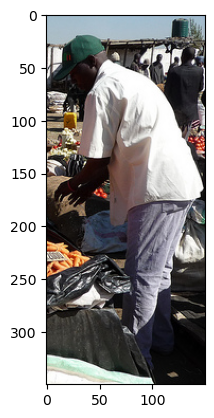

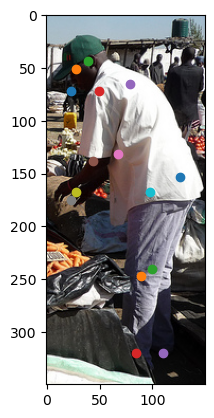

In [168]:
import matplotlib.pyplot as plt
image_test = cv2.imread('/home/gsc/mmpose/data/coco/train2017/000000262145.jpg')#262145
#image_test = cv2.imread(f'/home/gsc/mmpose/data/coco/train2017/000000{image_id_list[5]}.jpg')#262145
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
image_test = image_test[50:400,380:530] #150x350
image_test0 = image_test.copy()
plt.imshow(image_test)
plt.show()
transform = A.Compose([
                        A.Resize(192,256), #height : 192, width:192
                        #A.RandomResizedCrop(height=size, width=size, scale=(0.3, 1.0)),               
                        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                        ToTensorV2()
                        ])
image_test = transform(image=image_test)['image'].to(device)
image_test = image_test[None,:,:,:]
#print(image_test.shape)
infer_model.to(device)
infer_model.eval()
    
model_preds = []
    
with torch.no_grad():
    model_pred = infer_model(image_test).detach().cpu().numpy()[0]
#print(model_pred.shape)
final = 0
plt.imshow(image_test0)

for key in model_pred:
    large = np.max(key)
    #print(large)
    if large>=0.5:
        
        y_x = np.where(key==large)
        #print(np.array(y_x).flatten())
        plt.scatter(int(y_x[1]*(150/64)),int(y_x[0]*(350/48)))
plt.show()

In [217]:
random_seed=42
randomstate = np.random.RandomState(random_seed)

In [201]:
print(random)

RandomState(MT19937)


In [211]:
random.random()

0.6011150117432088

In [214]:
random.random()

0.9699098521619943

In [215]:
random.random()

0.8324426408004217

In [232]:
randomstate.random()

0.21233911067827616

In [273]:
randomstate.random()

0.5978999788110851

positions_2d
metadata
{'S1': {'Directions 1': [array([[[473.6836, 444.9426],
        [500.9961, 448.0299],
        [479.8392, 530.7856],
        ...,
        [508.1343, 356.4916],
        [520.3154, 413.3184],
        [515.4716, 456.43  ]],

       [[473.6876, 444.9527],
        [500.9846, 448.0307],
        [479.8167, 530.7858],
        ...,
        [508.162 , 356.4559],
        [520.4719, 413.2927],
        [514.9992, 456.2008]],

       [[473.6931, 444.9663],
        [500.9775, 448.0405],
        [479.7977, 530.7958],
        ...,
        [508.1776, 356.4026],
        [520.6623, 413.2636],
        [514.7042, 456.0594]],

       ...,

       [[508.909 , 435.9862],
        [531.6987, 432.5205],
        [531.796 , 525.6735],
        ...,
        [540.0052, 348.7834],
        [554.8098, 404.4597],
        [551.3666, 450.2952]],

       [[508.9323, 435.9889],
        [531.6936, 432.5266],
        [531.8196, 525.6773],
        ...,
        [540.0381, 348.8252],
        [554.7012, 404.5554

In [274]:
# make dataset test
_cameras_ex = copy.deepcopy(h36m_cameras_extrinsic_params)
_cameras_in = copy.deepcopy(h36m_cameras_intrinsic_params)
data_3d = np.load('data_3d_h36m.npz',allow_pickle=True)
data_2d_gt = np.load('data_2d_h36m_gt.npz',allow_pickle=True)
data_2d_cpn = np.load('data_2d_h36m_cpn_ft_h36m_dbb.npz',allow_pickle=True)

data2 = data_2d_gt['positions_2d'].item()
data3 = data_3d['positions_3d'].item()

_data2 = {}
for subject, actions in data2.items():
    #print(subject)
    _data2[subject] = {}
    #print(actions.items())
    for action_name, positions in actions.items():
        _data2[subject][action_name] = {
                    'positions': positions,
                    'cameras_in': _cameras_in,
                    'cameras_ex': _cameras_ex[subject],}
_data3 = {}
for subject, actions in data3.items():
    #print(subject)
    _data3[subject] = {}
    #print(actions.items())
    for action_name, positions in actions.items():
         _data3[subject][action_name] = {
                    'positions': positions,
                    'cameras_in': _cameras_in,
                    'cameras_ex': _cameras_ex[subject],}

data2d_test = np.array(_data2['S1']['Walking']['positions'])[0][0]
data3d_test = np.array(_data3['S1']['Walking']['positions'])[0]

In [287]:
subject_list = list(_data2.keys())
print(subject_list)
pose_list = list(_data2['S1'].keys())
print(pose_list)

['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']
['Directions 1', 'Photo 1', 'SittingDown 2', 'Eating', 'WalkDog 1', 'WalkDog', 'Purchases', 'Posing', 'Directions', 'Walking', 'Greeting', 'Phoning 1', 'Posing 1', 'Sitting 2', 'Waiting 1', 'Photo', 'Purchases 1', 'Greeting 1', 'Sitting 1', 'Smoking 1', 'WalkTogether', 'Waiting', 'WalkTogether 1', 'SittingDown', 'Phoning', 'Eating 2', 'Walking 1', 'Smoking', 'Discussion', 'Discussion 1']


In [289]:
subject_list = list(_data3.keys())
print(subject_list)
pose_list = list(_data3['S1'].keys())
print(pose_list)

['S1', 'S5', 'S6', 'S7', 'S8', 'S9', 'S11']
['Directions 1', 'Photo 1', 'SittingDown 2', 'Eating', 'WalkDog 1', 'WalkDog', 'Purchases', 'Posing', 'Directions', 'Walking', 'Greeting', 'Phoning 1', 'Posing 1', 'Sitting 2', 'Waiting 1', 'Photo', 'Purchases 1', 'Greeting 1', 'Sitting 1', 'Smoking 1', 'WalkTogether', 'Waiting', 'WalkTogether 1', 'SittingDown', 'Phoning', 'Eating 2', 'Walking 1', 'Smoking', 'Discussion', 'Discussion 1']


In [324]:
_data2['S5'].keys()

dict_keys(['Directions 1', 'Discussion 2', 'Eating', 'WalkDog 1', 'Discussion 3', 'Eating 1', 'WalkDog', 'Purchases', 'Posing', 'Walking', 'Phoning 1', 'Posing 1', 'Greeting 2', 'Waiting 1', 'Photo', 'Purchases 1', 'Greeting 1', 'Sitting 1', 'Smoking 1', 'Waiting 2', 'WalkTogether', 'Sitting', 'WalkTogether 1', 'SittingDown', 'Phoning', 'Directions 2', 'Photo 2', 'SittingDown 1', 'Walking 1', 'Smoking'])

In [327]:
k = 1
for i in subject_list:
    print(i)
    pose_list = list(_data2[i].keys())
    for j in pose_list:
        print(j)
        print(_data2[i][j]['positions'])
        k+=1
print(k)

S1
Directions 1
[array([[[473.6836, 444.9426],
        [500.9961, 448.0299],
        [479.8392, 530.7856],
        ...,
        [508.1343, 356.4916],
        [520.3154, 413.3184],
        [515.4716, 456.43  ]],

       [[473.6876, 444.9527],
        [500.9846, 448.0307],
        [479.8167, 530.7858],
        ...,
        [508.162 , 356.4559],
        [520.4719, 413.2927],
        [514.9992, 456.2008]],

       [[473.6931, 444.9663],
        [500.9775, 448.0405],
        [479.7977, 530.7958],
        ...,
        [508.1776, 356.4026],
        [520.6623, 413.2636],
        [514.7042, 456.0594]],

       ...,

       [[508.909 , 435.9862],
        [531.6987, 432.5205],
        [531.796 , 525.6735],
        ...,
        [540.0052, 348.7834],
        [554.8098, 404.4597],
        [551.3666, 450.2952]],

       [[508.9323, 435.9889],
        [531.6936, 432.5266],
        [531.8196, 525.6773],
        ...,
        [540.0381, 348.8252],
        [554.7012, 404.5554],
        [550.6077, 450.2513

[array([[[438.4641, 403.674 ],
        [462.5254, 400.2636],
        [464.4356, 496.5344],
        ...,
        [477.4767, 302.5059],
        [533.221 , 313.7448],
        [572.8766, 313.8173]],

       [[438.4311, 403.6773],
        [462.489 , 400.2688],
        [464.4208, 496.5394],
        ...,
        [477.4543, 302.5151],
        [533.1865, 313.7263],
        [572.8001, 313.7811]],

       [[438.3978, 403.6753],
        [462.4545, 400.2713],
        [464.4039, 496.541 ],
        ...,
        [477.4277, 302.5235],
        [533.1536, 313.6917],
        [572.7396, 313.7429]],

       ...,

       [[483.6315, 395.5397],
        [493.4979, 391.8536],
        [481.2814, 475.3897],
        ...,
        [501.961 , 316.916 ],
        [506.8457, 365.6192],
        [463.6498, 361.6669]],

       [[483.2024, 395.5672],
        [493.4831, 391.8862],
        [481.2822, 475.406 ],
        ...,
        [501.9977, 317.3085],
        [508.8046, 366.1746],
        [465.5266, 365.8817]],

       [[48

In [329]:
_data2

{'S1': {'Directions 1': {'positions': [array([[[473.6836, 444.9426],
            [500.9961, 448.0299],
            [479.8392, 530.7856],
            ...,
            [508.1343, 356.4916],
            [520.3154, 413.3184],
            [515.4716, 456.43  ]],
    
           [[473.6876, 444.9527],
            [500.9846, 448.0307],
            [479.8167, 530.7858],
            ...,
            [508.162 , 356.4559],
            [520.4719, 413.2927],
            [514.9992, 456.2008]],
    
           [[473.6931, 444.9663],
            [500.9775, 448.0405],
            [479.7977, 530.7958],
            ...,
            [508.1776, 356.4026],
            [520.6623, 413.2636],
            [514.7042, 456.0594]],
    
           ...,
    
           [[508.909 , 435.9862],
            [531.6987, 432.5205],
            [531.796 , 525.6735],
            ...,
            [540.0052, 348.7834],
            [554.8098, 404.4597],
            [551.3666, 450.2952]],
    
           [[508.9323, 435.9889],
  